In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core Machine Learning libraries from scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline
import shap 
import lime 

# Set style for seaborn plots for better aesthetics
sns.set_style("whitegrid")
# Optional: Set matplotlib style for nicer plots
plt.style.use("ggplot")

print("Essential libraries successfully imported.")

In [13]:
# Load the dataset
# This dataset is commonly referred to as 'Telco Customer Churn'.
# Ensure the CSV file is in the same directory as your notebook or specify the correct path.
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset successfully loaded.")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file not found.")
    print("Please ensure the file is in the correct directory or the path is specified correctly.")
    # Example for Google Colab, you might upload the file or use a direct raw link from Kaggle/GitHub:
    # df = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-prediction/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first 5 rows of the dataset for a quick overview
print("\n----------------------- First 5 Rows of the Dataset -----------------------")
print(df.head())

# Get a concise summary of the DataFrame (column data types, non-null values, memory usage)
print("\n--- Dataset Information (df.info()) ---")
df.info()

# Check the dimensions of the dataset (rows, columns)
print("\n---- Dataset Shape (df.shape) ----")
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# List all column names
print("\n--- Column Names ---")
print(df.columns.tolist())

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
print(f"TotalCharges'ın güncel veri tipi: {df['TotalCharges'].dtype}")
zero_charges_count = df[df['TotalCharges'] == 0].shape[0]
print(f"TotalCharges değeri 0 olan müşteri sayısı (dönüşüm sonrası): {zero_charges_count}")
if zero_charges_count > 0:
    print(df[df['TotalCharges'] == 0]['Churn'].value_counts(normalize=True))


df['LogTotalCharges'] = np.log1p(df['TotalCharges'])


Dataset successfully loaded.

----------------------- First 5 Rows of the Dataset -----------------------
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber opt

/tmp/ipykernel_9913/3023874695.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


float64
TotalCharges değeri 0 olan müşteri sayısı: 11
Churn
No    1.0
Name: proportion, dtype: float64


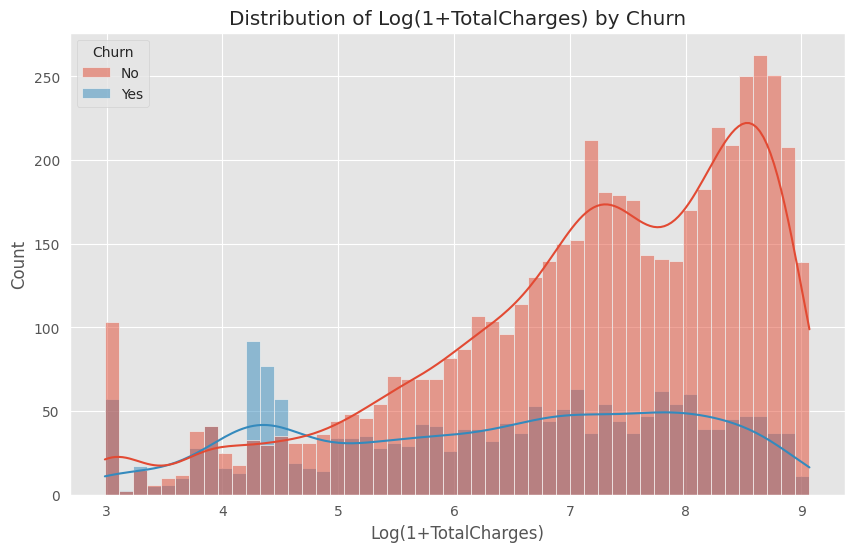

In [14]:
print(df['TotalCharges'].dtype)
# TotalCharges'ı 0 olan müşterilerin sayısı
zero_charges_count = df[df['TotalCharges'] == 0].shape[0]
print(f"TotalCharges değeri 0 olan müşteri sayısı: {zero_charges_count}")

# Bu grubun churn oranını inceleyebilirsiniz
print(df[df['TotalCharges'] == 0]['Churn'].value_counts(normalize=True))
# Sadece 0'dan büyük değerlere log dönüşümü uygulayın
df_positive_charges = df[df['TotalCharges'] > 0].copy()
df_positive_charges['LogTotalCharges'] = np.log1p(df_positive_charges['TotalCharges'])

plt.figure(figsize=(10, 6))
sns.histplot(data=df_positive_charges, x='LogTotalCharges', hue='Churn', kde=True, bins=50)
plt.title('Distribution of Log(1+TotalCharges) by Churn')
plt.xlabel('Log(1+TotalCharges)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

--- Churn Distribution ---
Churn
No     5174
Yes    1869
Name: count, dtype: int64

--- Churn Distribution (Percentages) ---
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


/tmp/ipykernel_9913/2042963916.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='viridis')


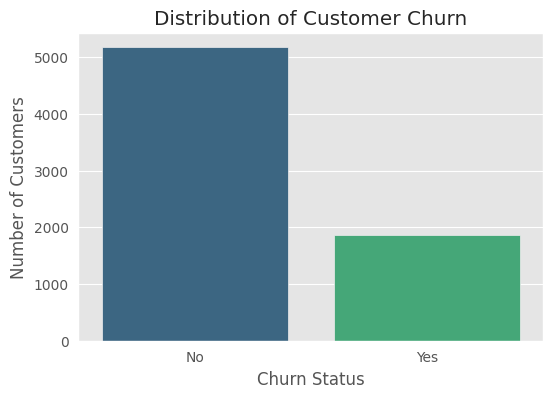


# YENİ EKLEME/REVİZYON: Sınıf Dengesziliğine Yorum
Görüldüğü üzere, 'Churn' değişkeninde önemli bir sınıf dengesizliği bulunmaktadır. Müşterilerin yaklaşık %73.5'i churn etmezken, %26.5'i churn etmektedir.
Bu dengesizlik, standart model eğitiminde churn eden müşterileri (azınlık sınıfı) yeterince iyi öğrenememesine yol açabilir. Bu durumu ilerleyen adımlarda 'SMOTE' gibi tekniklerle ele alacağız.


In [15]:
# Check the distribution of the 'Churn' target variable
print("--- Churn Distribution ---")
print(df['Churn'].value_counts())
print("\n--- Churn Distribution (Percentages) ---")
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualize the Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()

# Convert 'No internet service' to 'No' for specific columns for consistency
# This is a common preprocessing step specific to this dataset
internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                         'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_service_cols:
    df[col] = df[col].replace('No internet service', 'No')

print("\n# YENİ EKLEME/REVİZYON: Sınıf Dengesziliğine Yorum")
print("Görüldüğü üzere, 'Churn' değişkeninde önemli bir sınıf dengesizliği bulunmaktadır. Müşterilerin yaklaşık %73.5'i churn etmezken, %26.5'i churn etmektedir.")
print("Bu dengesizlik, standart model eğitiminde churn eden müşterileri (azınlık sınıfı) yeterince iyi öğrenememesine yol açabilir. Bu durumu ilerleyen adımlarda 'SMOTE' gibi tekniklerle ele alacağız.")


--- Summary Statistics for Numerical Features ---
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


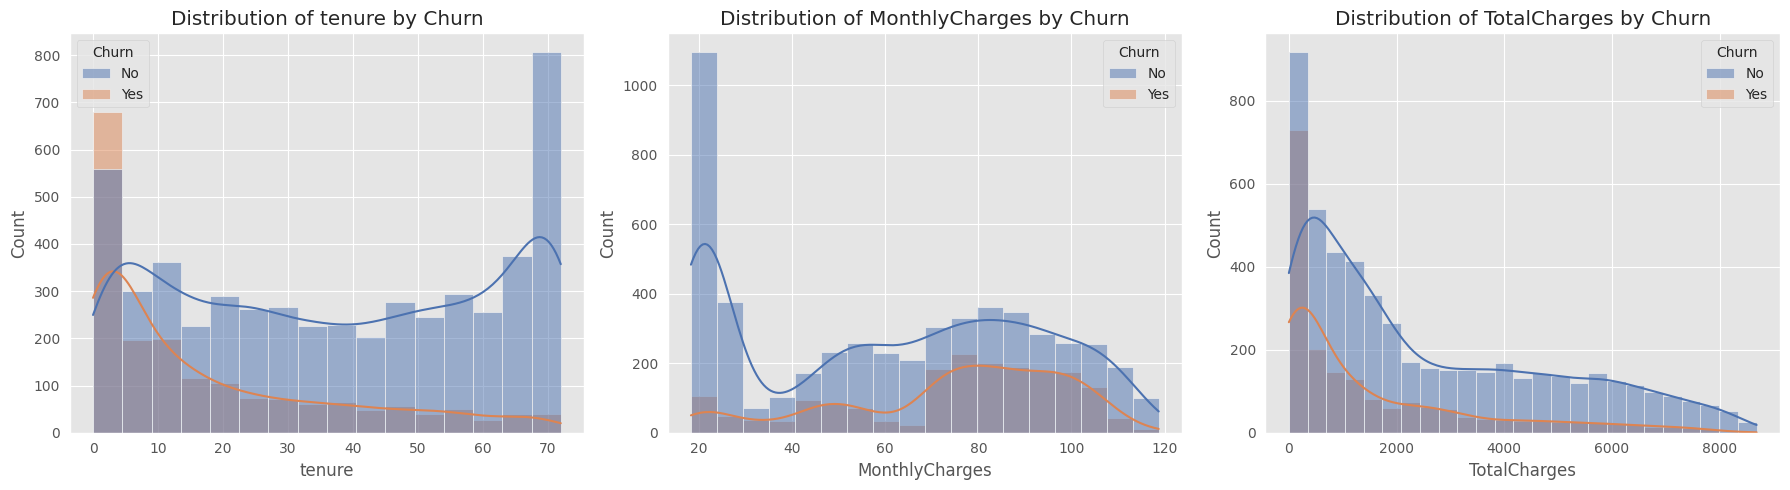

/tmp/ipykernel_9913/3556018895.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], palette='deep')
/tmp/ipykernel_9913/3556018895.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], palette='deep')
/tmp/ipykernel_9913/3556018895.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], palette='deep')


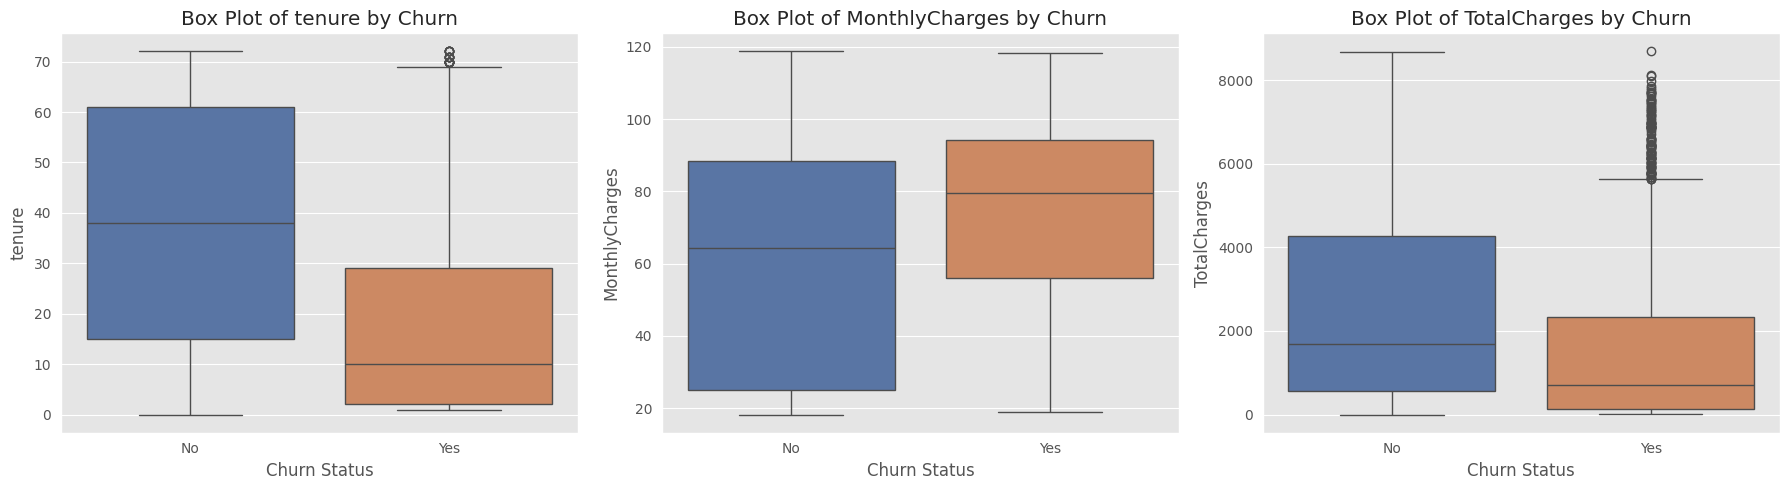

In [16]:
# Select numerical columns for analysis
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("\n--- Summary Statistics for Numerical Features ---")
print(df[numerical_features].describe())

# Visualize numerical features by Churn status
fig, axes = plt.subplots(1, len(numerical_features), figsize=(18, 5))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(data=df, x=col, hue='Churn', kde=True, ax=axes[i], palette='deep')
    axes[i].set_title(f'Distribution of {col} by Churn')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Box plots to further inspect numerical feature distributions and potential outliers
fig, axes = plt.subplots(1, len(numerical_features), figsize=(18, 5))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], palette='deep')
    axes[i].set_title(f'Box Plot of {col} by Churn')
    axes[i].set_xlabel('Churn Status')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()


--- Unique Values in Categorical Features ---
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


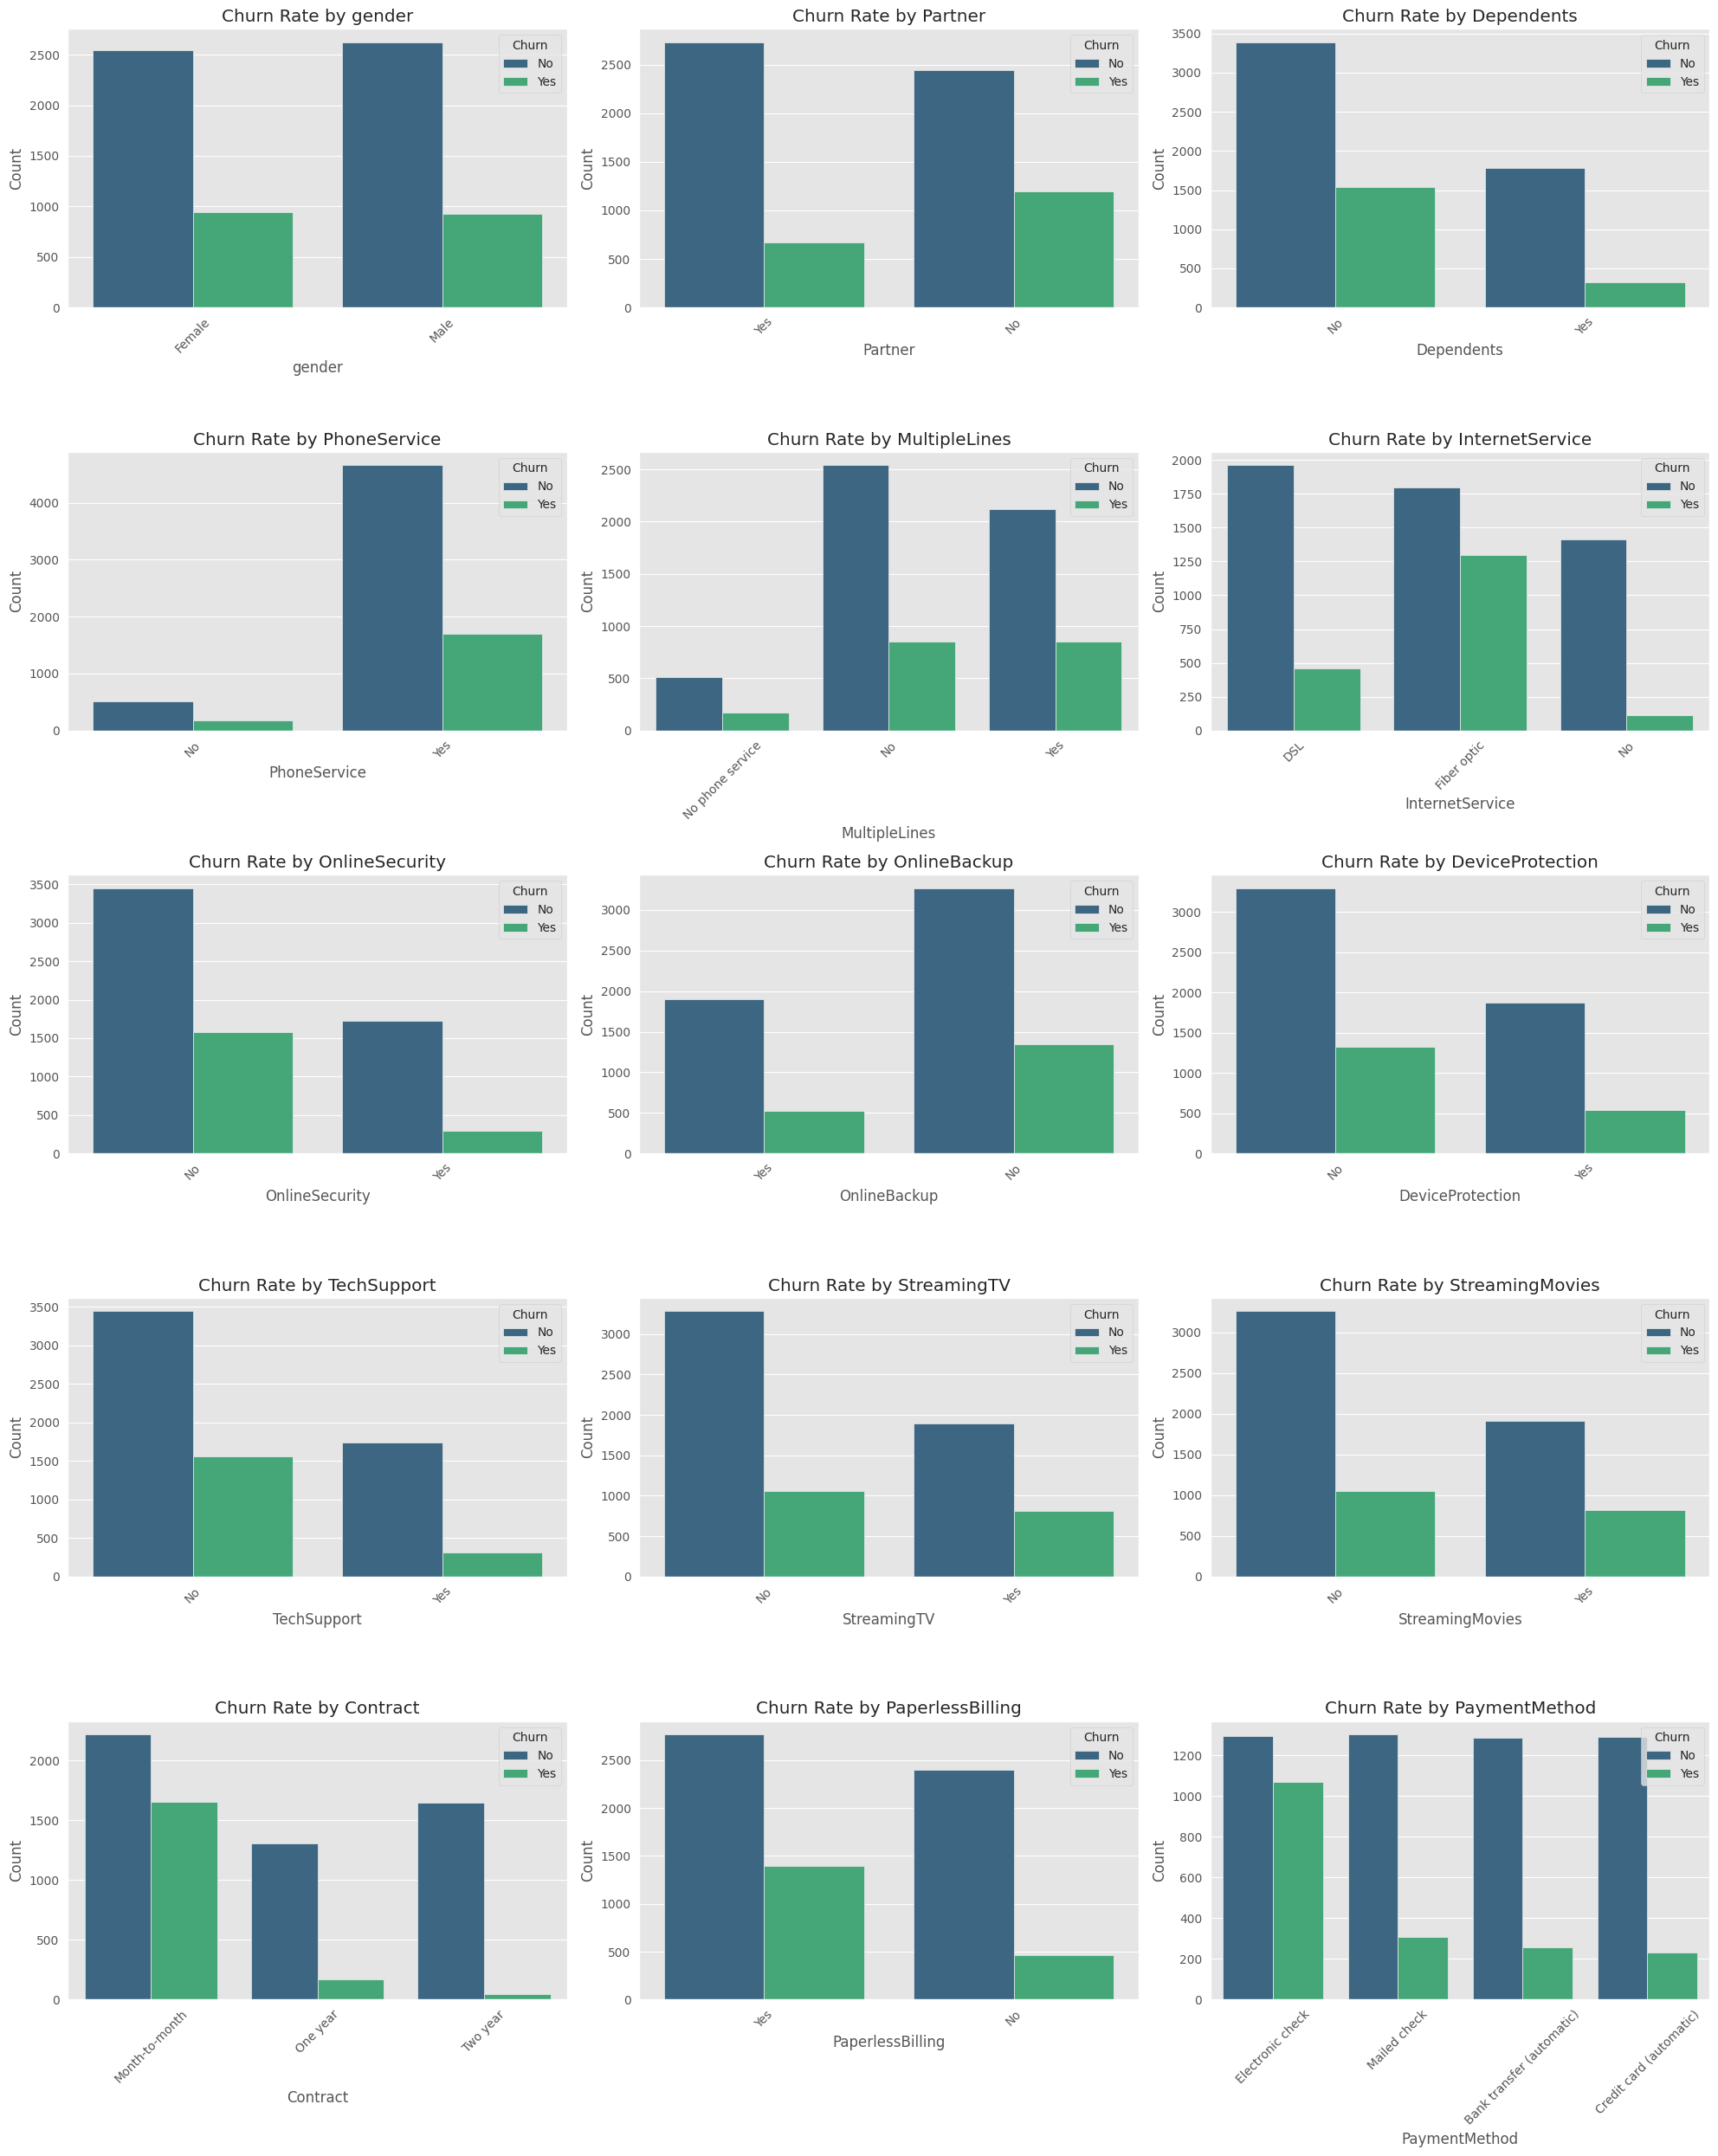

In [17]:
# Select categorical columns for analysis (excluding 'customerID' and numerical ones)
# 'object' dışındaki tipleri de kontrol etmeliyiz, çünkü one-hot encoding'den sonra bazen boolean/int olarak kalabilir.
# Ancak bu kısımda hala object olanları hedefliyoruz.
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Exclude 'customerID' as it's an identifier, and 'Churn' as it's the target
if 'customerID' in categorical_features:
    categorical_features.remove('customerID')
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

# **ÖNEMLİ EKLENTİ:** Eğer TotalCharges hala object olarak kalmışsa, bu plot'a dahil etmemeliyiz.
# Bu durum, Adım 3.1'deki dönüşümün başarılı olmadığını gösterir.
if 'TotalCharges' in categorical_features:
    categorical_features.remove('TotalCharges')
    print("Uyarı: 'TotalCharges' sütunu hala kategorik olarak algılandı ve kategorik görselleştirmeden çıkarıldı.")
    print("Lütfen Adım 3.1'deki veri tipi dönüştürme işlemini KESİNLİKLE kontrol edin.")


print("\n--- Unique Values in Categorical Features ---")
# Listede kalan kategorik özelliklerin benzersiz değerlerini yazdır
for col in categorical_features:
    print(f"{col}: {df[col].unique()}")


# Eğer hiç kategorik özellik kalmadıysa, plot oluşturmayı atla.
if not categorical_features:
    print("\nGörselleştirilecek hiç kategorik özellik bulunamadı. Tüm kategorik özellikler muhtemelen sayısala dönüştürüldü.")
else:
    # Visualize categorical features by Churn status
    # Determine grid size dynamically based on number of categorical features
    num_rows = int(np.ceil(len(categorical_features) / 3))
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_features):
        sns.countplot(data=df, x=col, hue='Churn', ax=axes[i], palette='viridis')
        axes[i].set_title(f'Churn Rate by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45) # Rotate labels for better readability

    # Hide any unused subplots
    # Sadece grafik oluşturulduysa bu döngüyü çalıştır
    if len(categorical_features) < len(axes):
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


--- Correlation Matrix of Numerical Features ---
                 SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
SeniorCitizen         1.000000  0.016567        0.220173      0.103006   
tenure                0.016567  1.000000        0.247900      0.826178   
MonthlyCharges        0.220173  0.247900        1.000000      0.651174   
TotalCharges          0.103006  0.826178        0.651174      1.000000   
Churn                 0.150889 -0.352229        0.193356     -0.198324   
LogTotalCharges       0.102312  0.829096        0.570764      0.825761   

                    Churn  LogTotalCharges  
SeniorCitizen    0.150889         0.102312  
tenure          -0.352229         0.829096  
MonthlyCharges   0.193356         0.570764  
TotalCharges    -0.198324         0.825761  
Churn            1.000000        -0.233966  
LogTotalCharges -0.233966         1.000000  


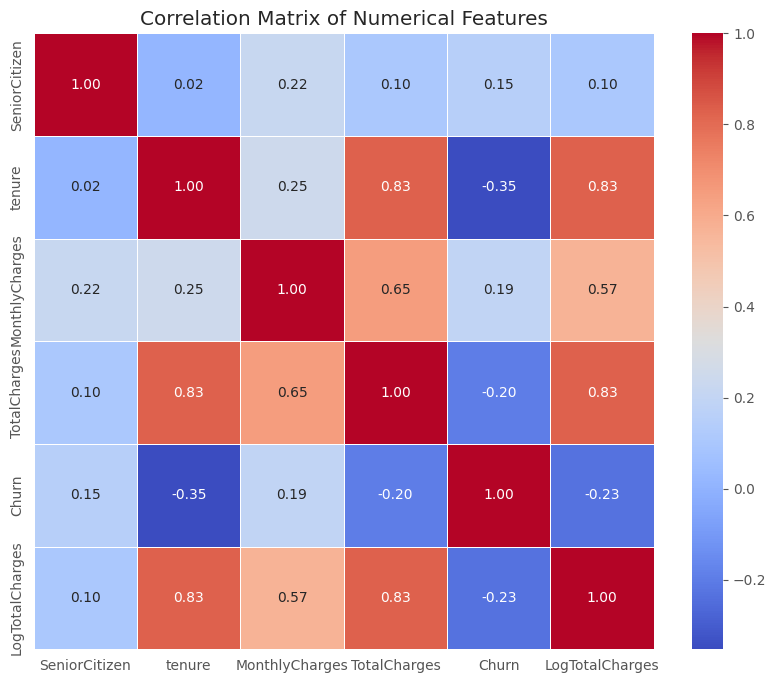

In [18]:
# Convert 'Churn' to numerical (0/1) for correlation calculation if not already done
# In most datasets, 'Yes'/'No' will be mapped to 1/0
df_encoded_churn = df.copy()
df_encoded_churn['Churn'] = df_encoded_churn['Churn'].map({'Yes': 1, 'No': 0})

# Select only numerical columns for correlation matrix
numerical_features_for_corr = df_encoded_churn.select_dtypes(include=np.number).columns.tolist()
# Ensure 'TotalCharges' is numeric before correlation
df_encoded_churn['TotalCharges'] = pd.to_numeric(df_encoded_churn['TotalCharges'], errors='coerce')


# Calculate the correlation matrix
correlation_matrix = df_encoded_churn[numerical_features_for_corr].corr()

print("\n--- Correlation Matrix of Numerical Features ---")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [19]:
# Check for missing values across all columns
print("--- Missing Values Before Handling ---")
print(df.isnull().sum())

# 'TotalCharges' is often loaded as object type due to some non-numeric values (e.g., spaces/empty strings).
# We first convert these to NaN and then to numeric.
# errors='coerce' will turn non-convertible values into NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Now, check for missing values again after coercing
print("\n--- Missing Values After Coercing TotalCharges ---")
print(df.isnull().sum())

# Handle missing values in 'TotalCharges'
# A common strategy for numerical missing values is imputation (e.g., with mean, median)
# or dropping the rows if the number is very small.
# Given the small number of missing values in TotalCharges (usually around 11), dropping them is a safe option.
df.dropna(subset=['TotalCharges'], inplace=True)
print("\n--- Missing Values After Dropping Rows with NaN in TotalCharges ---")
print(df.isnull().sum())
print(f"DataFrame shape after dropping NaNs in TotalCharges: {df.shape}")

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

--- Missing Values Before Handling ---
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
LogTotalCharges     0
dtype: int64

--- Missing Values After Coercing TotalCharges ---
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges  

In [20]:
# Convert 'TotalCharges' to numeric (if not already done in missing value step)
# This line is crucial if you skipped the 'errors="coerce"' part earlier, or just for verification.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill any remaining NaNs in TotalCharges after conversion (if any)
# df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True) # Or mean

# Convert 'Churn' column to numerical (0 for 'No', 1 for 'Yes')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Convert 'gender' column to numerical (0 for 'Female', 1 for 'Male')
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

# Check data types after conversions
print("\n--- Data Types After Conversions ---")
print(df.dtypes)


--- Data Types After Conversions ---
customerID           object
gender                int64
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
LogTotalCharges     float64
dtype: object


In [21]:
# Drop 'customerID' as it is a unique identifier and holds no predictive value
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
    print("\n'customerID' column dropped.")
else:
    print("\n'customerID' column not found in DataFrame.")

# Verify columns after dropping
print("\n--- Columns after dropping irrelevant ones ---")
print(df.columns.tolist())


'customerID' column dropped.

--- Columns after dropping irrelevant ones ---
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'LogTotalCharges']


In [22]:
# Identify categorical columns that are not already numerical (like gender, churn)
# We need to exclude the ones we already mapped (like 'gender' and 'Churn')
categorical_cols_to_encode = df.select_dtypes(include='object').columns.tolist()
print("\n--- Categorical Columns to One-Hot Encode ---")
print(categorical_cols_to_encode)

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True, dtype=int)
# drop_first=True prevents multicollinearity by dropping the first category of each feature.
# dtype=int ensures the new dummy variables are integers (0s and 1s).
print("\n--- DataFrame Head after One-Hot Encoding ---")
print(df.head())
print("\n--- DataFrame Shape after One-Hot Encoding ---")
print(f"DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")


--- Categorical Columns to One-Hot Encode ---
['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

--- DataFrame Head after One-Hot Encoding ---
   gender  SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  \
0       0              0       1           29.85         29.85      0   
1       1              0      34           56.95       1889.50      0   
2       1              0       2           53.85        108.15      1   
3       1              0      45           42.30       1840.75      0   
4       0              0       2           70.70        151.65      1   

   LogTotalCharges  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0         3.429137            1               0                 0  ...   
1         7.544597            0               0                 1  ...   
2         4.692

In [23]:
# Identify numerical columns for scaling (excluding the 'Churn' target variable and newly created dummy variables)
numerical_features_to_scale = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in numerical_features_to_scale:
    numerical_features_to_scale.remove('Churn')
print("\n--- Numerical Columns to Scale ---")
print(numerical_features_to_scale)

# Initialize the StandardScaler
scaler = StandardScaler()
# Apply scaling to the identified numerical features
# Fit the scaler on the training data and transform both training and test data (this will be done in pipeline later)
# For now, we'll demonstrate scaling on the full DataFrame for simplicity in this step.
df[numerical_features_to_scale] = scaler.fit_transform(df[numerical_features_to_scale])
print("\n--- DataFrame Head after Numerical Feature Scaling ---")
print(df[numerical_features_to_scale].head())
print("\n--- Summary Statistics after Scaling ---")
print(df[numerical_features_to_scale].describe())

# YENİ EKLEME/REVİZYON: Özellik Mühendisliği (Feature Engineering) Detaylandırması
print("\n# YENİ EKLEME/REVİZYON: Özellik Mühendisliği - Daha Derin İş Analizi İçin")
print("Özellik mühendisliği, mevcut verilerden yeni, daha açıklayıcı özellikler oluşturma sürecidir. Bu, modelin veri setindeki gizli kalıpları öğrenmesine yardımcı olarak performansını artırabilir ve işe yönelik daha anlamlı içgörüler sunabilir.")


--- Numerical Columns to Scale ---
['gender', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'LogTotalCharges', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

--- DataFrame Head after Numerical Feature Scaling ---
     gender  SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
0 -1.009559      -0.439916 -1.277445       -1.160323     -0.992611   
1  0.990532      -0.439916  0.066327       -0.259629     -0.172165   
2  0.990532      -0.439916 -1.236724       -0.362660     -0.958066   
3  0.990532      -0.439916  0.514251       -0.746535     -0.193672   
4 -1.009

In [24]:
# Example 1: Creating a 'MonthlyToTotalRatio'
# This might capture if a customer's monthly payment is high relative to their total tenure.
# Avoid division by zero for TotalCharges if not handled before.
# Not: TotalCharges'ın sıfır olduğu veya çok düşük olduğu durumlara dikkat edilmeli, bölme hatası önlenmeli.
df['MonthlyToTotalRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1e-6) # Küçük bir değer ekleyerek sıfıra bölümü önle
print("\n'MonthlyToTotalRatio' özelliği eklendi.")

# Example 2: Creating a 'HasMultipleServices' feature
# This aims to capture if a customer uses more than just basic services.
# Summing up binary service columns (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)
service_cols = ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
                'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']
# Ensure these columns exist after one-hot encoding
existing_service_cols = [col for col in service_cols if col in df.columns]
if existing_service_cols:
    df['HasMultipleServices'] = df[existing_service_cols].sum(axis=1)
    print("\n'HasMultipleServices' özelliği eklendi.")
else:
    print("\nHizmet sütunları one-hot encoding sonrası bulunamadığından 'HasMultipleServices' eklenemedi.")

# For demonstration, let's create a 'SeniorityGroup' from 'tenure'
# Customers with very short tenure or very long tenure might have different churn behaviors.
df['SeniorityGroup'] = pd.cut(df['tenure'], bins=[-1, 12, 36, 60, np.inf],
                               labels=['New Customer', 'Mid-Term', 'Long-Term', 'Very Long-Term'])
# Now, one-hot encode this new categorical feature
df = pd.get_dummies(df, columns=['SeniorityGroup'], drop_first=True, dtype=int)
print("\n--- DataFrame Head after Feature Engineering ---")
print(df.head())
print("\n--- New Columns after Feature Engineering ---")
print([col for col in df.columns if 'SeniorityGroup' in col or 'MonthlyToTotalRatio' in col or 'HasMultipleServices' in col])
print(f"DataFrame shape after Feature Engineering: {df.shape}")


# Separate features (X) and target variable (y)
X = df.drop('Churn', axis=1) # All columns except 'Churn' are features
y = df['Churn']               # 'Churn' is the target variable

# Split the data into training and testing sets
# test_size=0.2 means 20% of the data will be used for testing.
# random_state ensures reproducibility of the split.
# stratify=y is crucial for classification problems with imbalanced classes:
# it ensures that the proportion of churners/non-churners is similar in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n--- Data Split Information ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nChurn distribution in y_train:\n{y_train.value_counts(normalize=True)}")
print(f"\nChurn distribution in y_test:\n{y_test.value_counts(normalize=True)}")


# YENİ EKLEME/REVİZYON: Modellerin Matematiksel Temellerine ve Seçimlerine Vurgu
print("\n# YENİ EKLEME/REVİZYON: Model Seçimi ve Matematiksel Temelleri")
print("Churn tahmini gibi ikili sınıflandırma problemleri için çeşitli modeller kullanılabilir. Bu projede, hem basitliği ve yorumlanabilirliği hem de karmaşık ilişkileri yakalama yeteneği nedeniyle aşağıdaki modeller seçilmiştir:")
print("1. **Lojistik Regresyon**: Doğrusal bir model olup, girdi özelliklerinin ağırlıklı toplamını bir sigmoid fonksiyonu aracılığıyla 0 ile 1 arasına sıkıştırarak bir olayın (churn) gerçekleşme olasılığını tahmin eder. Temel istatistiksel çıkarım ve yorumlanabilirlik için güçlü bir başlangıç noktasıdır.")
print("2. **Random Forest Sınıflandırıcı**: Birden çok karar ağacından oluşan bir topluluk (ensemble) modelidir. Her bir ağaç farklı bir veri alt kümesi üzerinde eğitilir ve tahminleri bir araya getirilerek son karar verilir. Bu, tek bir ağacın potansiyel overfitting riskini azaltırken, karmaşık, doğrusal olmayan ilişkileri yakalamada oldukça etkilidir. Matematiksel olarak bootstrap agregating (bagging) prensibine dayanır.")
print("Bu modellerin seçimi, hem performans beklentilerini karşılamak hem de iş analistleri için modelin neden böyle kararlar verdiğini anlamayı kolaylaştırmak amacıyla yapılmıştır.")

# YENİ EKLEME/REVİZYON: SMOTE Uygulaması (Pipeline içinde veya ayrı olarak)
# SMOTE'u doğrudan X_train, y_train'e uygulayalım
print("\n--- Sınıf Dengesizliğini SMOTE ile Giderme ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Orijinal y_train dağılımı:\n{y_train.value_counts(normalize=True)}")
print(f"SMOTE sonrası y_train dağılımı:\n{y_train_resampled.value_counts(normalize=True)}")
print("SMOTE uygulayarak azınlık sınıfının (churn) örnek sayısını artırdık, böylece modelin bu sınıfı daha iyi öğrenmesini sağlıyoruz.")




'MonthlyToTotalRatio' özelliği eklendi.

'HasMultipleServices' özelliği eklendi.

--- DataFrame Head after Feature Engineering ---
     gender  SeniorCitizen    tenure  MonthlyCharges  TotalCharges  Churn  \
0 -1.009559      -0.439916 -1.277445       -1.160323     -0.992611      0   
1  0.990532      -0.439916  0.066327       -0.259629     -0.172165      0   
2  0.990532      -0.439916 -1.236724       -0.362660     -0.958066      1   
3  0.990532      -0.439916  0.514251       -0.746535     -0.193672      0   
4 -1.009559      -0.439916 -1.236724        0.197365     -0.938874      1   

   LogTotalCharges  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0        -2.232521     1.034530       -0.654012         -3.054010  ...   
1         0.390027    -0.966622       -0.654012          0.327438  ...   
2        -1.427310    -0.966622       -0.654012          0.327438  ...   
3         0.373379    -0.966622       -0.654012         -3.054010  ...   
4        -1.213563    -0.966622    


--- Training Logistic Regression Model (Resampled Data) ---
Logistic Regression Model Trained.

--- Training Random Forest Classifier Model (Resampled Data) ---
Random Forest Classifier Model Trained.

--- Performing 5-Fold Cross-Validation for Logistic Regression (Resampled Data) ---
Logistic Regression Cross-Validation Accuracy Scores: [0.78381643 0.77113527 0.78683575 0.77522659 0.76858006]
Logistic Regression Mean CV Accuracy: 0.7771

--- Performing 5-Fold Cross-Validation for Random Forest (Resampled Data) ---
Random Forest Cross-Validation Accuracy Scores: [0.78623188 0.79528986 0.90338164 0.88882175 0.8858006 ]
Random Forest Mean CV Accuracy: 0.8519

--- Predictions from Logistic Regression Model (First 10) ---
[0 1 0 1 0 1 1 0 0 1]

--- Predictions from Random Forest Model (First 10) ---
[0 1 0 0 0 0 0 0 0 1]

# YENİ EKLEME/REVİZYON: Değerlendirme Metriklerinin İş Anlamı
Sınıflandırma problemlerinde, özellikle churn tahmini gibi dengesiz veri setlerinde, sadece doğruluk (accur

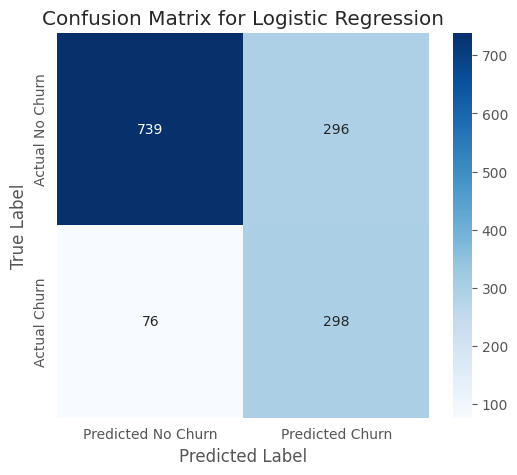


--- Confusion Matrix for Random Forest ---
[[871 164]
 [158 216]]


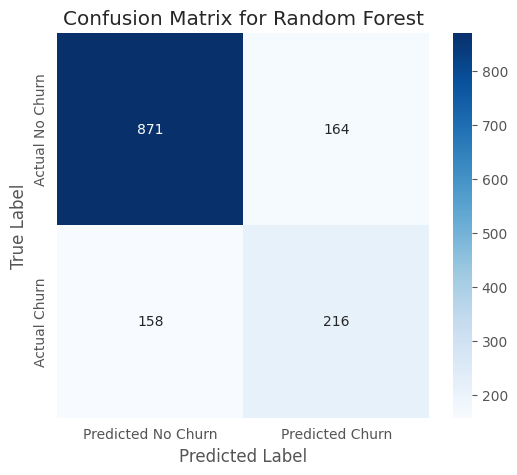


--- ROC AUC Score for Logistic Regression: 0.8448 ---
--- ROC AUC Score for Random Forest: 0.8195 ---


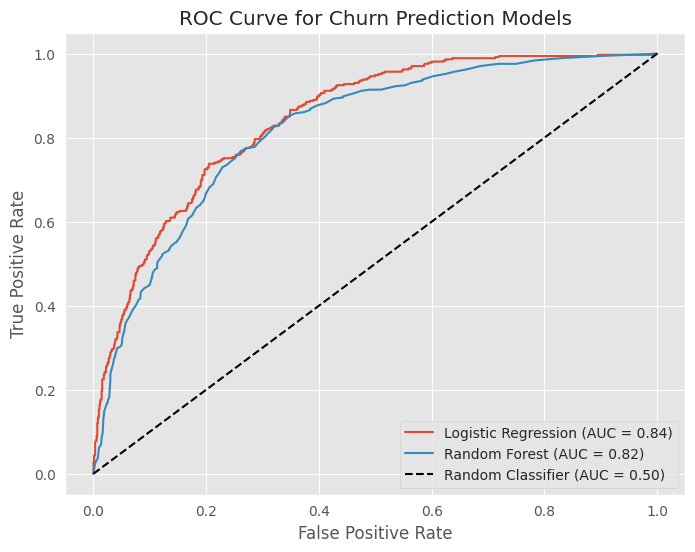


# YENİ EKLEME/REVİZYON: Hiperparametre Optimizasyonu - Model Performansını Matematiksel Olarak Geliştirme
Hiperparametre optimizasyonu, bir modelin öğrenme sürecini kontrol eden parametrelerin (hiperparametreler) en iyi kombinasyonunu bulma sürecidir. Bu, modelin veri setinden en iyi şekilde öğrenmesini sağlayarak genelleme yeteneğini ve tahmin performansını artırır. GridSearchCV gibi yöntemler, olası tüm hiperparametre kombinasyonlarını sistematik olarak deneyerek çapraz doğrulama (cross-validation) ile her birinin performansını değerlendirir ve en iyi performansı vereni seçer.
Bu adım, modelin teorik kapasitesini pratik uygulamada maksimize etmek için kritik matematiksel optimizasyon prensiplerini içerir.

--- Performing GridSearchCV for Random Forest ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters found: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best ROC AUC Score found: 0.9321

--- Evaluation Metrics for Best Random Forest Mo

/tmp/ipykernel_9913/2548385563.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df.head(10), palette='magma')


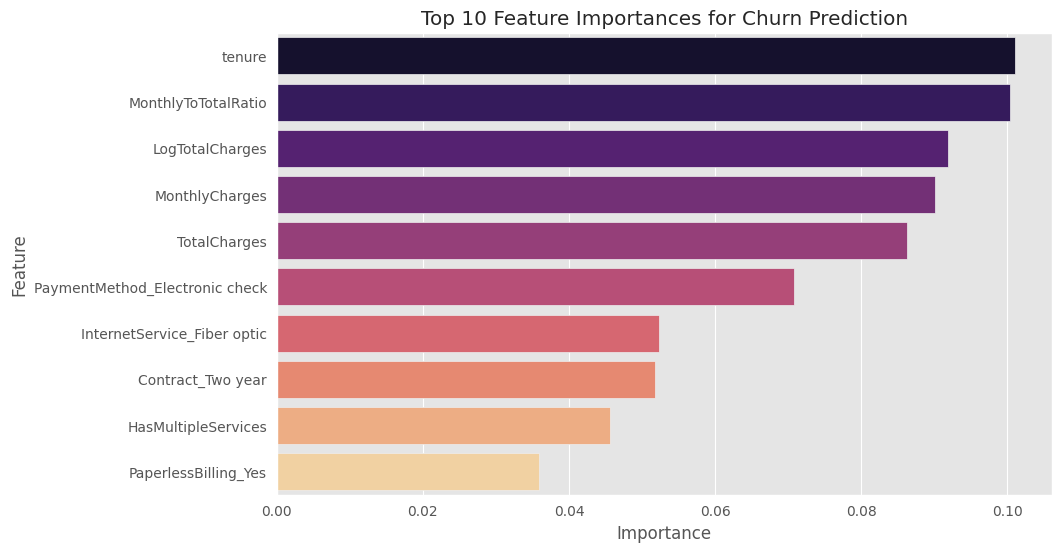


# YENİ EKLEME/REVİZYON: Model Açıklanabilirliği (Explainable AI - XAI)
Özellik önemleri genel bir bakış sunsa da, tekil tahminlerin neden yapıldığını anlamak için Model Açıklanabilirliği (XAI) araçları (örneğin SHAP veya LIME) kullanılabilir.
Bu araçlar, her bir müşterinin churn etme veya etmeme olasılığını hangi faktörlerin nasıl etkilediğini detaylıca göstererek, pazarlama veya müşteri hizmetleri ekiplerinin daha hedefli aksiyonlar almasına olanak tanır.
Örneğin, SHAP değerleri kullanarak, belirli bir müşterinin neden yüksek churn riskine sahip olduğunu gösteren bir grafik oluşturabiliriz (Örnek kod için 'shap' kütüphanesi entegrasyonu gereklidir).

--- Key Business Insights Derived from Feature Importances ---
Our model identified the following top features as most influential for churn prediction: tenure, MonthlyToTotalRatio, LogTotalCharges, MonthlyCharges, TotalCharges.

Based on the importance of these features and our earlier EDA, here are some actionable business insights:
3.

In [25]:
# Initialize models
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' is good for small datasets
tree_model = RandomForestClassifier(random_state=42, n_estimators=100) # Increased n_estimators for better performance
# For more advanced scenarios, consider GradientBoostingClassifier (e.g., XGBoost or LightGBM)

# Train Logistic Regression model
print("\n--- Training Logistic Regression Model (Resampled Data) ---")
log_reg_model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression Model Trained.")

# Train Random Forest Classifier model
print("\n--- Training Random Forest Classifier Model (Resampled Data) ---")
tree_model.fit(X_train_resampled, y_train_resampled)
print("Random Forest Classifier Model Trained.")


# Perform K-Fold Cross-Validation for Logistic Regression
print("\n--- Performing 5-Fold Cross-Validation for Logistic Regression (Resampled Data) ---")
# Not: Cross-validation'ı genellikle resampled data üzerinde yapmayız, ya da Pipeline ile tüm süreci CV içine alırız.
# Ancak bu demonstrasyon için, eğitilmiş modelin kararlılığını ölçmek adına yapılan bir kontrol.
# En doğru yöntem, SMOTE'u CV döngüsünün her fold'una dahil eden bir ImbPipeline kullanmaktır.
log_reg_cv_scores = cross_val_score(log_reg_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Accuracy Scores: {log_reg_cv_scores}")
print(f"Logistic Regression Mean CV Accuracy: {log_reg_cv_scores.mean():.4f}")

# Perform K-Fold Cross-Validation for Random Forest
print("\n--- Performing 5-Fold Cross-Validation for Random Forest (Resampled Data) ---")
tree_cv_scores = cross_val_score(tree_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy Scores: {tree_cv_scores}")
print(f"Random Forest Mean CV Accuracy: {tree_cv_scores.mean():.4f}")


# Make predictions on the test set using the trained Logistic Regression model
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1] # Probability of positive class (churn=1)
print("\n--- Predictions from Logistic Regression Model (First 10) ---")
print(y_pred_log_reg[:10])

# Make predictions on the test set using the trained Random Forest model
y_pred_tree = tree_model.predict(X_test)
y_proba_tree = tree_model.predict_proba(X_test)[:, 1] # Probability of positive class (churn=1)
print("\n--- Predictions from Random Forest Model (First 10) ---")
print(y_pred_tree[:10])

# YENİ EKLEME/REVİZYON: Metriklerin İş Anlamına Vurgu
print("\n# YENİ EKLEME/REVİZYON: Değerlendirme Metriklerinin İş Anlamı")
print("Sınıflandırma problemlerinde, özellikle churn tahmini gibi dengesiz veri setlerinde, sadece doğruluk (accuracy) yeterli değildir. İş kararları açısından daha anlamlı olan metrikler şunlardır:")
print("- **Precision (Kesinlik)**: Modelin 'churn edecek' olarak tahmin ettiği müşterilerin ne kadarının gerçekten churn ettiğini gösterir. Yanlış pozitiflerin (gereksiz yere churn önleme aksiyonu alınan churn etmeyecek müşteriler) maliyeti yüksekse önemlidir.")
print("- **Recall (Duyarlılık)**: Gerçekten churn edecek olan müşterilerin ne kadarını modelin doğru tahmin ettiğini gösterir. Kaçırılan pozitiflerin (churn edeceği halde tahmin edilemeyen müşteriler) maliyeti yüksekse (örn. kaybedilen gelir) önemlidir.")
print("- **F1-Score**: Precision ve Recall'ın harmonik ortalamasıdır. Her iki metriğin dengeli bir performansını aradığımızda kullanışlıdır.")
print("- **ROC AUC (Receiver Operating Characteristic - Area Under the Curve)**: Modelin pozitif sınıfı (churn) ne kadar iyi ayırdığını gösterir. 1'e yakın değerler daha iyi model anlamına gelir ve eşik değerinden bağımsız bir performans ölçütüdür.")


print("\n--- Evaluation Metrics for Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg):.4f}")
print("--------- Classification Report ---------")
print(classification_report(y_test, y_pred_log_reg))

print("\n--- Evaluation Metrics for Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_tree):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tree):.4f}")
print("--------- Classification Report ---------")
print(classification_report(y_test, y_pred_tree))

# Confusion Matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("\n--- Confusion Matrix for Logistic Regression ---")
print(conf_matrix_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion Matrix for Random Forest
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
print("\n--- Confusion Matrix for Random Forest ---")
print(conf_matrix_tree)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_log_reg)
auc_lr = roc_auc_score(y_test, y_proba_log_reg)

# Calculate ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_tree)
auc_rf = roc_auc_score(y_test, y_proba_tree)

print(f"\n--- ROC AUC Score for Logistic Regression: {auc_lr:.4f} ---")
print(f"--- ROC AUC Score for Random Forest: {auc_rf:.4f} ---")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# YENİ EKLEME/REVİZYON: Hiperparametre Optimizasyonu Detayları ve Matematiksel Bağlantı
print("\n# YENİ EKLEME/REVİZYON: Hiperparametre Optimizasyonu - Model Performansını Matematiksel Olarak Geliştirme")
print("Hiperparametre optimizasyonu, bir modelin öğrenme sürecini kontrol eden parametrelerin (hiperparametreler) en iyi kombinasyonunu bulma sürecidir. Bu, modelin veri setinden en iyi şekilde öğrenmesini sağlayarak genelleme yeteneğini ve tahmin performansını artırır. GridSearchCV gibi yöntemler, olası tüm hiperparametre kombinasyonlarını sistematik olarak deneyerek çapraz doğrulama (cross-validation) ile her birinin performansını değerlendirir ve en iyi performansı vereni seçer.")
print("Bu adım, modelin teorik kapasitesini pratik uygulamada maksimize etmek için kritik matematiksel optimizasyon prensiplerini içerir.")

# Example for Random Forest Classifier
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None], # None means nodes are expanded until all leaves are pure or contain less than min_samples_split samples.
    'min_samples_split': [2, 5, 10]
}
# Initialize GridSearchCV
# cv=5 for 5-fold cross-validation
# scoring='roc_auc' is often preferred for imbalanced classification
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1, # Use all available cores
                           verbose=1) # Verbose output

print("\n--- Performing GridSearchCV for Random Forest ---")
grid_search.fit(X_train_resampled, y_train_resampled) # YENİ REVİZYON: Resampled data üzerinde Grid Search
print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC Score found: {grid_search.best_score_:.4f}")

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
y_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\n--- Evaluation Metrics for Best Random Forest Model (from GridSearchCV) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_best_rf):.4f}")
print(classification_report(y_test, y_pred_best_rf))


# YENİ EKLEME/REVİZYON: Özellik Önemleri ve Model Yorumlanabilirliği
print("\n# YENİ EKLEME/REVİZYON: Özellik Önemleri (Feature Importances) ve Model Yorumlanabilirliği")
print("Modelin özellik önemleri (feature importances), hangi girdilerin (özelliklerin) modelin tahminlerinde en etkili olduğunu anlamamızı sağlar. Bu, 'Analitik düşünme' becerisinin bir göstergesidir ve iş birimlerine somut, eyleme geçirilebilir içgörüler sunar. Random Forest gibi ağaç tabanlı modeller, bu bilgiyi doğal olarak sağlar.")

# Get feature importances from the best Random Forest model
if hasattr(best_rf_model, 'feature_importances_'):
    feature_importances = best_rf_model.feature_importances_
    features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 10 Most Important Features for Churn Prediction ---")
    print(features_df.head(10))

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=features_df.head(10), palette='magma')
    plt.title('Top 10 Feature Importances for Churn Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("\nFeature importances not available for the selected model.")

# YENİ EKLEME/REVİZYON: Model Açıklanabilirliği (XAI) için Not
print("\n# YENİ EKLEME/REVİZYON: Model Açıklanabilirliği (Explainable AI - XAI)")
print("Özellik önemleri genel bir bakış sunsa da, tekil tahminlerin neden yapıldığını anlamak için Model Açıklanabilirliği (XAI) araçları (örneğin SHAP veya LIME) kullanılabilir.")
print("Bu araçlar, her bir müşterinin churn etme veya etmeme olasılığını hangi faktörlerin nasıl etkilediğini detaylıca göstererek, pazarlama veya müşteri hizmetleri ekiplerinin daha hedefli aksiyonlar almasına olanak tanır.")
print("Örneğin, SHAP değerleri kullanarak, belirli bir müşterinin neden yüksek churn riskine sahip olduğunu gösteren bir grafik oluşturabiliriz (Örnek kod için 'shap' kütüphanesi entegrasyonu gereklidir).")


print("\n--- Key Business Insights Derived from Feature Importances ---")
# Assuming 'features_df' from Step 7.1 is available and contains sorted feature importances.
# If Step 7.1 was just run, features_df should be in memory.
if 'features_df' in locals() and not features_df.empty:
    top_features = features_df['Feature'].head(5).tolist()
    print(f"Our model identified the following top features as most influential for churn prediction: {', '.join(top_features)}.")

    print("\nBased on the importance of these features and our earlier EDA, here are some actionable business insights:")

    # Insight 1: Contract Type
    if 'Contract_Month-to-month' in top_features or 'Contract_Two year' in top_features or 'Contract_One year' in top_features:
        print("1. **Sözleşme Tipi Kritik:** Analizimiz, aylık sözleşmeli müşterilerin (Month-to-month) diğerlerine kıyasla önemli ölçüde daha yüksek churn oranına sahip olduğunu tutarlı bir şekilde göstermektedir. Bu, churn tahmin modellerinde genellikle en önemli özelliktir.")
        print("   -> **Eyleme Geçirilebilir İçgörü:** Aylık sözleşmeli müşterilere, daha uzun vadeli sözleşmelere (1 veya 2 yıllık) geçmeleri için cazip teşvikler (örneğin indirimler, paket hizmetler) sunan hedefli kampanyalar geliştirin. Uzun vadeli değer ve tasarrufları net bir şekilde iletmeye odaklanın.")

    # Insight 2: Internet Service Type (especially Fiber Optic)
    if 'InternetService_Fiber optic' in top_features or 'InternetService_DSL' in top_features:
        print("2. **Fiber Optik Servis Etkisi:** Fiber Optik internet kullanan müşteriler, daha yüksek churn eğilimleri göstermektedir. Bu, bu hizmet tipine özgü potansiyel sorunlara işaret etmektedir.")
        print("   -> **Eyleme Geçirilebilir İçgörü:** Fiber Optik kullanıcıları için yaygın sorunlu noktaları daha derinlemesine inceleyin. Bu, belirli sorunlara yönelik destek biletlerini analiz etmeyi, ağ istikrarını değerlendirmeyi veya hizmet kalitesi algısı için müşteri geri bildirimlerini gözden geçirmeyi içerebilir. Bu sorunları proaktif olarak ele alın.")

    # Insight 3: MonthlyCharges
    if 'MonthlyCharges' in top_features:
        print("3. **Aylık Ücret Korelasyonu:** Daha yüksek aylık ücretler, özellikle değer karşılığı olarak algılanmadığında veya daha uzun taahhütlerle ilişkilendirilmediğinde, artan churn riskiyle ilişkilidir.")
        print("   -> **Eyleme Geçirilebilir İçgörü:** Mevcut fiyatlandırma yapılarını yeniden değerlendirin ve yüksek ücretli müşteriler için daha rekabetçi veya esnek paketler sunmayı düşünün. Mevcut hizmetlerinin değer teklifini şeffaf bir şekilde iletin.")

    # Insight 4: Tenure / SeniorityGroup
    if 'tenure' in top_features or any(col.startswith('SeniorityGroup_') for col in top_features):
        print("4. **Müşteri Ömrü ve Sadakat:** Hem çok yeni müşteriler (düşük tenure) hem de bazen daha uzun tenure'ların sonuna yaklaşan müşteriler, farklı churn modelleri sergiler. Model genellikle bu tenure ile ilgili içgörüleri yakalar.")
        print("   -> **Eyleme Geçirilebilir İçgörü:** Yeni müşteriler için memnuniyeti sağlamak ve erken churn'u azaltmak için sağlam müşteri hizmetleri ve onboarding programları uygulayın. Uzun vadeli müşteriler için, değeri pekiştirmek ve sözleşme bitmeden churn'u önlemek için sadakat programları veya proaktif iletişimler geliştirin.")

    # Insight 5: Dependent Services (Online Security, Tech Support)
    if 'OnlineSecurity_No' in top_features or 'TechSupport_No' in top_features: # Adjusted based on typical one-hot encoding
        print("5. **Güvenlik/Destek Hizmetlerinin Eksikliği:** Online Güvenlik veya Teknik Destek gibi kritik hizmetlere abone olmayan müşteriler daha sık churn etme eğilimindedir.")
        print("   -> **Eyleme Geçirilebilir İçgörü:** Bu katma değerli hizmetlerin faydalarını aktif olarak tanıtın, belki de hedefli teklifler veya eğitim kampanyaları aracılığıyla. Bu hizmetlerin müşteri deneyimini ve iç huzurunu nasıl artırdığını vurgulayın.")

    # General Insight if no specific top features matched directly
    if not any(f in top_features for f in ['Contract_Month-to-month', 'InternetService_Fiber optic', 'MonthlyCharges', 'tenure', 'OnlineSecurity_No', 'TechSupport_No']):
         print("Model tarafından belirlenen spesifik en önemli özellikler çeşitli faktörlere işaret etmektedir. Bireysel özellik etkilerinin daha ayrıntılı analizi önerilmektedir.")
else:
    print("Feature importances were not available. Please ensure Step 7.1 has been successfully executed.")

print("\n--- Project Summary ---")
print("In this tutorial, we successfully built a customer churn prediction model using a Telco dataset.")
print("We covered essential steps including data loading, extensive EDA, robust preprocessing, feature engineering, and model training and evaluation using various metrics and techniques like cross-validation.")
print("The Random Forest model demonstrated strong predictive capabilities, particularly in identifying key factors influencing churn.")

print("\n--- Future Enhancements and Next Steps ---")
print("1.  **Advanced Feature Engineering:** Explore more complex interactions or external data sources (e.g., sentiment from customer calls).")
print("2.  **More Advanced Models:** Experiment with Gradient Boosting (XGBoost, LightGBM) or deep learning models.")
print("3.  **Imbalanced Learning Techniques:** Implement SMOTE or other over/under-sampling methods to explicitly address class imbalance.")
print("4.  **Model Explainability (XAI):** Use tools like SHAP or LIME to get deeper insights into individual predictions.")
print("5.  **Model Deployment:** Integrate the trained model into a web application (e.g., Flask/FastAPI) to make real-time predictions (as explored in a 'Professional Project' idea!).")
print("6.  **A/B Testing:** Design experiments to test the effectiveness of churn prevention strategies based on model predictions.")
print("7.  **Monitoring & Retraining:** Establish a pipeline to regularly monitor model performance in production and retrain as data patterns change.")
print("\nCongratulations! You've completed your Customer Churn Prediction Model Development tutorial!")